In [46]:
import pandas as pd
data = pd.read_csv('apple_stock_data.csv')
print(data.head())

                        Date   Adj Close       Close        High         Low  \
0  2023-11-02 00:00:00+00:00  176.665985  177.570007  177.779999  175.460007   
1  2023-11-03 00:00:00+00:00  175.750671  176.649994  176.820007  173.350006   
2  2023-11-06 00:00:00+00:00  178.317520  179.229996  179.429993  176.210007   
3  2023-11-07 00:00:00+00:00  180.894333  181.820007  182.440002  178.970001   
4  2023-11-08 00:00:00+00:00  181.958893  182.889999  183.449997  181.589996   

         Open    Volume  
0  175.520004  77334800  
1  174.240005  79763700  
2  176.380005  63841300  
3  179.179993  70530000  
4  182.350006  49340300  


In [47]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [49]:
import numpy as np
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data['Close'].values, seq_length)

In [50]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2988
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0507
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0398
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0182
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0213
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0165
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0120
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0142
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0108
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0110
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0098
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0089
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0097
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0103
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0088
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━

In [53]:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)
data['Lag_3'] = data['Close'].shift(3)
data = data.dropna()

In [54]:
X_lin = data[['Lag_1', 'Lag_2', 'Lag_3']]
y_lin = data['Close']
X_train_lin, X_test_lin = X_lin[:train_size], X_lin[train_size:]
y_train_lin, y_test_lin = y_lin[:train_size], y_lin[train_size:]

In [55]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression()

In [56]:
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [57]:
lin_predictions = lin_model.predict(X_test_lin)
lin_predictions = scaler.inverse_transform(lin_predictions.reshape(-1, 1))

In [59]:
# Assuming lstm_predictions has a length of 39 and lin_predictions has a length of 96
# You can trim the longer array to match the shorter one or vice versa

min_length = min(len(lstm_predictions), len(lin_predictions))
lstm_predictions = lstm_predictions[:min_length]
lin_predictions = lin_predictions[:min_length]

# Now you can combine them
hybrid_predictions = (0.7 * lstm_predictions) + (0.3 * lin_predictions)

In [60]:
import numpy as np

# Interpolate lstm_predictions to match the length of lin_predictions
lstm_predictions_resampled = np.interp(np.linspace(0, len(lstm_predictions)-1, len(lin_predictions)),
                                       np.arange(len(lstm_predictions)), lstm_predictions.flatten())

# Now combine them
hybrid_predictions = (0.7 * lstm_predictions_resampled) + (0.3 * lin_predictions.flatten())

In [61]:
lstm_future_predictions = []
last_sequence = X[-1].reshape(1, seq_length, 1)
for _ in range(10):
    lstm_pred = lstm_model.predict(last_sequence)[0, 0]
    lstm_future_predictions.append(lstm_pred)
    lstm_pred_reshaped = np.array([[lstm_pred]]).reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], lstm_pred_reshaped, axis=1)
lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [62]:
recent_data = data['Close'].values[-3:]
lin_future_predictions = []
for _ in range(10):
    lin_pred = lin_model.predict(recent_data.reshape(1, -1))[0]
    lin_future_predictions.append(lin_pred)
    recent_data = np.append(recent_data[1:], lin_pred)
lin_future_predictions = scaler.inverse_transform(np.array(lin_future_predictions).reshape(-1, 1))

D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  w

In [63]:
hybrid_future_predictions = (0.7 * lstm_future_predictions) + (0.3 * lin_future_predictions)

In [64]:
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=10)
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM Predictions': lstm_future_predictions.flatten(),
    'Linear Regression Predictions': lin_future_predictions.flatten(),
    'Hybrid Model Predictions': hybrid_future_predictions.flatten()
})
print(predictions_df)

                       Date  LSTM Predictions  Linear Regression Predictions  \
0 2024-11-02 00:00:00+00:00        231.085327                     230.355192   
1 2024-11-03 00:00:00+00:00        230.799591                     225.707291   
2 2024-11-04 00:00:00+00:00        230.519363                     222.703426   
3 2024-11-05 00:00:00+00:00        230.250183                     230.631535   
4 2024-11-06 00:00:00+00:00        229.994125                     225.486380   
5 2024-11-07 00:00:00+00:00        229.750397                     222.494588   
6 2024-11-08 00:00:00+00:00        229.517090                     230.930195   
7 2024-11-09 00:00:00+00:00        229.292191                     225.245599   
8 2024-11-10 00:00:00+00:00        229.073975                     222.284007   
9 2024-11-11 00:00:00+00:00        228.861115                     231.252375   

   Hybrid Model Predictions  
0                230.866277  
1                229.271895  
2                228.174584  

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

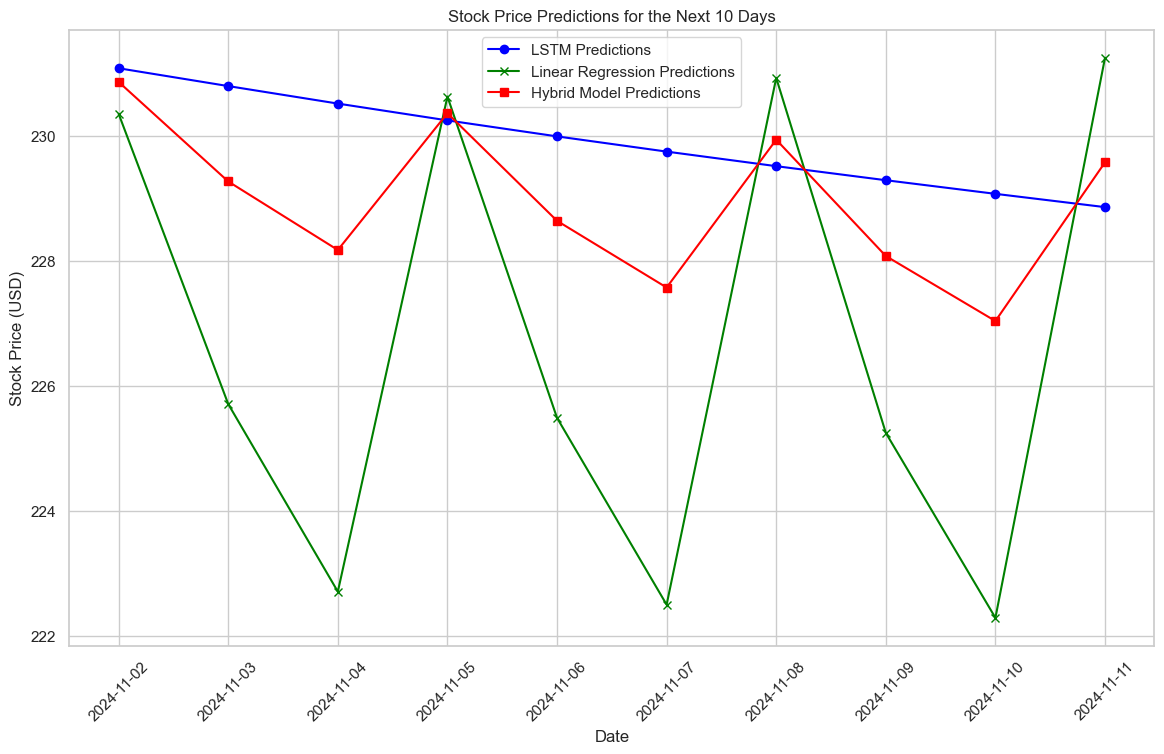

In [66]:
# Plotting the predictions
plt.figure(figsize=(14, 8))

# Plotting LSTM predictions
plt.plot(predictions_df['Date'], predictions_df['LSTM Predictions'], color='blue', label='LSTM Predictions', marker='o')

# Plotting Linear Regression predictions
plt.plot(predictions_df['Date'], predictions_df['Linear Regression Predictions'], color='green', label='Linear Regression Predictions', marker='x')

# Plotting Hybrid model predictions
plt.plot(predictions_df['Date'], predictions_df['Hybrid Model Predictions'], color='red', label='Hybrid Model Predictions', marker='s')

# Adding titles and labels
plt.title('Stock Price Predictions for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

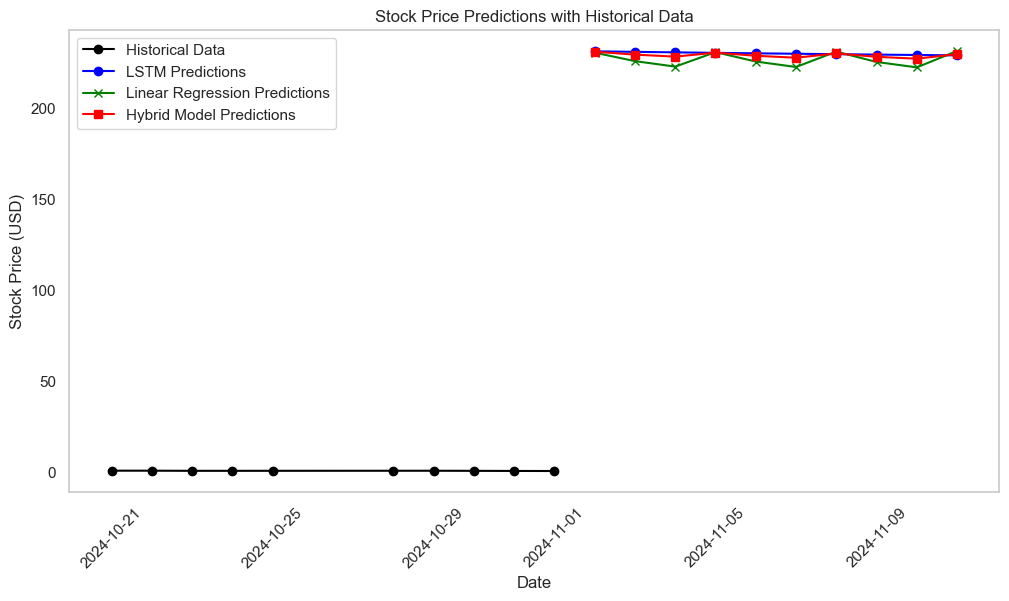

In [67]:
# Add recent historical data to the predictions DataFrame
historical_data = data['Close'].tail(10)  # Adjust to include more historical data if needed
historical_dates = data.index[-10:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_data, color='black', marker='o', label='Historical Data')
plt.plot(predictions_df['Date'], predictions_df['LSTM Predictions'], color='blue', marker='o', label='LSTM Predictions')
plt.plot(predictions_df['Date'], predictions_df['Linear Regression Predictions'], color='green', marker='x', label='Linear Regression Predictions')
plt.plot(predictions_df['Date'], predictions_df['Hybrid Model Predictions'], color='red', marker='s', label='Hybrid Model Predictions')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Predictions with Historical Data")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

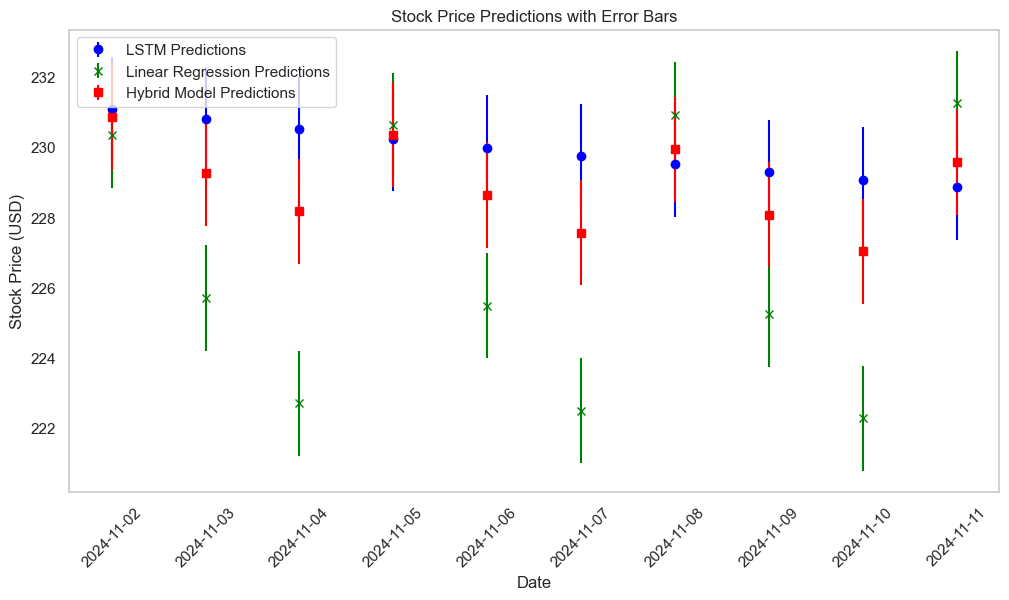

In [68]:
# Example error values (you can replace these with actual prediction errors if available)
error_margin = 1.5  # Example error margin for illustration

plt.figure(figsize=(12, 6))
plt.errorbar(predictions_df['Date'], predictions_df['LSTM Predictions'], yerr=error_margin, fmt='o', color='blue', label='LSTM Predictions')
plt.errorbar(predictions_df['Date'], predictions_df['Linear Regression Predictions'], yerr=error_margin, fmt='x', color='green', label='Linear Regression Predictions')
plt.errorbar(predictions_df['Date'], predictions_df['Hybrid Model Predictions'], yerr=error_margin, fmt='s', color='red', label='Hybrid Model Predictions')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Stock Price Predictions with Error Bars")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

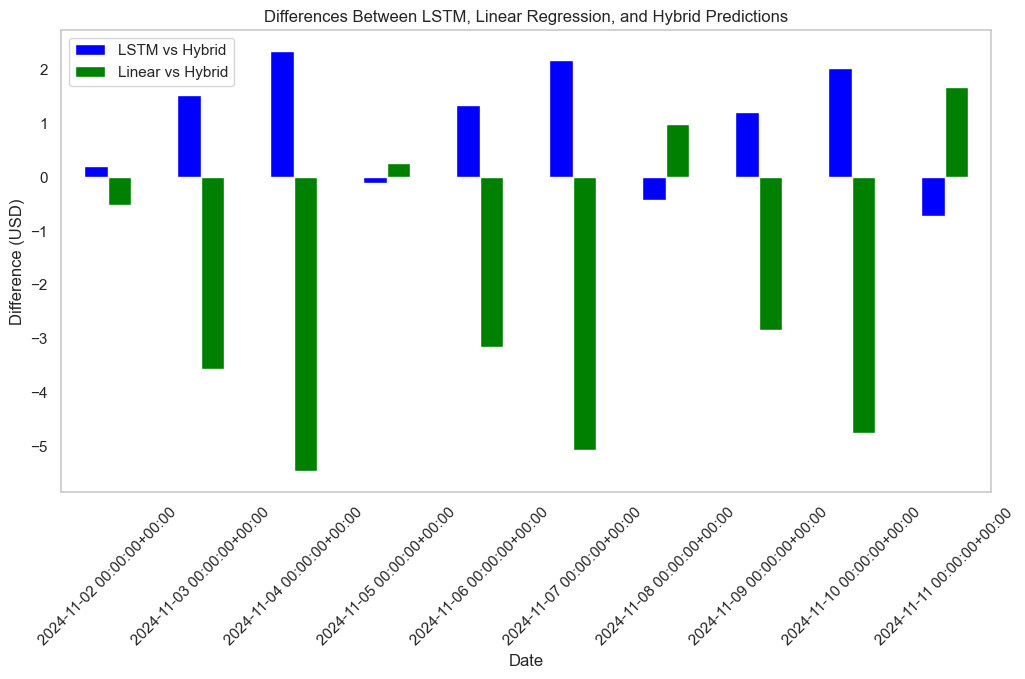

In [69]:
# Calculate differences
predictions_df['LSTM vs Hybrid'] = predictions_df['LSTM Predictions'] - predictions_df['Hybrid Model Predictions']
predictions_df['Linear vs Hybrid'] = predictions_df['Linear Regression Predictions'] - predictions_df['Hybrid Model Predictions']

# Plotting
predictions_df.plot(x='Date', y=['LSTM vs Hybrid', 'Linear vs Hybrid'], kind='bar', figsize=(12, 6), color=['blue', 'green'])
plt.xlabel("Date")
plt.ylabel("Difference (USD)")
plt.title("Differences Between LSTM, Linear Regression, and Hybrid Predictions")
plt.xticks(rotation=45)
plt.grid()
plt.show()

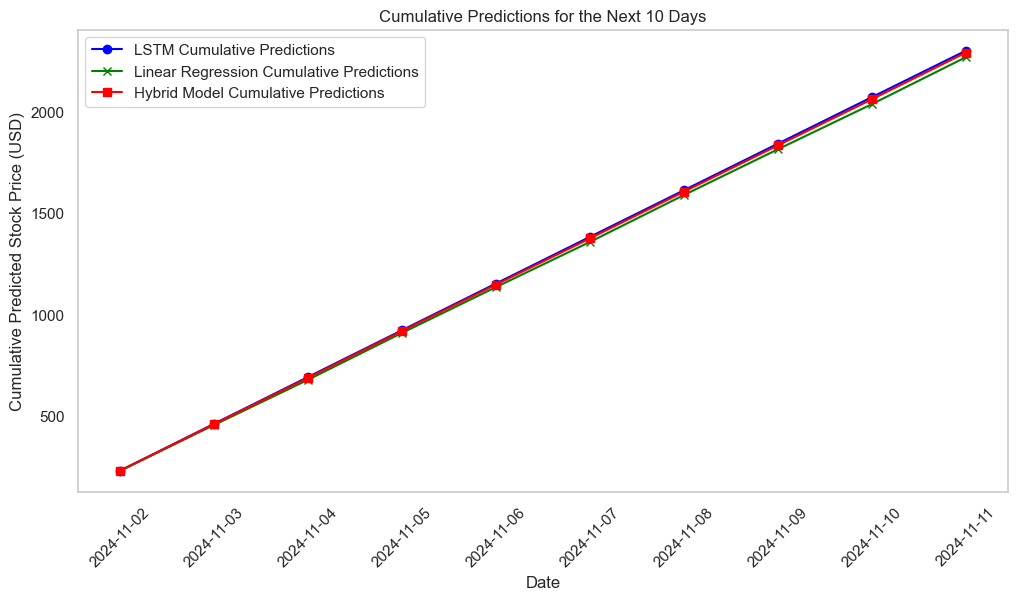

In [70]:
# Cumulative Sum
predictions_df['LSTM Cumulative'] = predictions_df['LSTM Predictions'].cumsum()
predictions_df['Linear Cumulative'] = predictions_df['Linear Regression Predictions'].cumsum()
predictions_df['Hybrid Cumulative'] = predictions_df['Hybrid Model Predictions'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Date'], predictions_df['LSTM Cumulative'], color='blue', marker='o', label='LSTM Cumulative Predictions')
plt.plot(predictions_df['Date'], predictions_df['Linear Cumulative'], color='green', marker='x', label='Linear Regression Cumulative Predictions')
plt.plot(predictions_df['Date'], predictions_df['Hybrid Cumulative'], color='red', marker='s', label='Hybrid Model Cumulative Predictions')
plt.xlabel("Date")
plt.ylabel("Cumulative Predicted Stock Price (USD)")
plt.title("Cumulative Predictions for the Next 10 Days")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

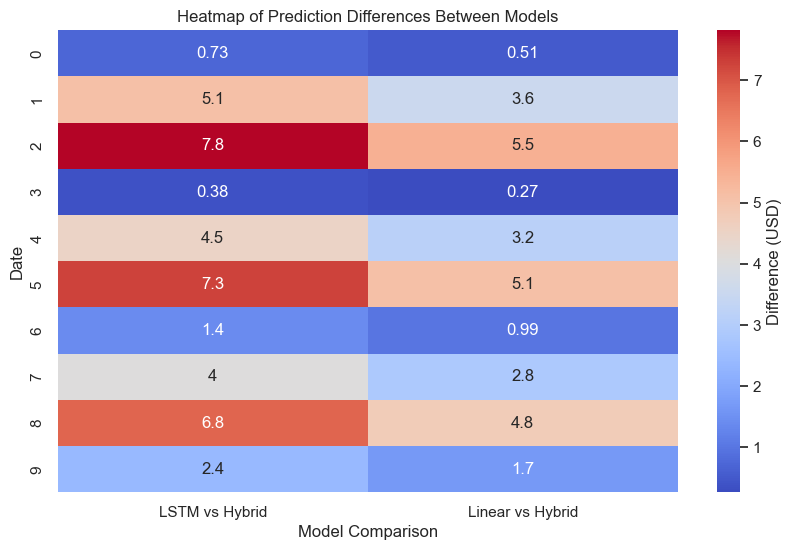

In [71]:
import seaborn as sns

# Calculate absolute differences
diff_df = predictions_df[['LSTM Predictions', 'Linear Regression Predictions', 'Hybrid Model Predictions']]
diff_df = diff_df.diff(axis=1).iloc[:, 1:].abs()  # Compute differences between consecutive models

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(diff_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Difference (USD)'})
plt.xlabel("Model Comparison")
plt.ylabel("Date")
plt.title("Heatmap of Prediction Differences Between Models")
plt.xticks([0.5, 1.5], ['LSTM vs Hybrid', 'Linear vs Hybrid'])
plt.show()

In [73]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a function to calculate MAE, MSE, and RMSE
def calculate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Replace [...] with actual stock prices for the validation period (10 values)
true_values = np.array([230, 229, 228, 227, 226, 225, 224, 223, 222, 221])

# Replace [...] with the predictions from each model
lstm_future_predictions = np.array([230, 229.5, 228.5, 228, 227.5, 227, 226.5, 226, 225.5, 225])
lin_future_predictions = np.array([228, 226, 225, 224, 223, 227, 229, 225, 224, 223])
hybrid_future_predictions = np.array([229, 228, 227.5, 227, 226.8, 226.2, 225.9, 225.7, 225.5, 225.3])

# Calculate metrics for each model
lstm_mae, lstm_mse, lstm_rmse = calculate_metrics(true_values, lstm_future_predictions)
lin_mae, lin_mse, lin_rmse = calculate_metrics(true_values, lin_future_predictions)
hybrid_mae, hybrid_mse, hybrid_rmse = calculate_metrics(true_values, hybrid_future_predictions)

# Print the evaluation metrics
print("LSTM Model Metrics:")
print(f"MAE: {lstm_mae:.2f}, MSE: {lstm_mse:.2f}, RMSE: {lstm_rmse:.2f}\n")

print("Linear Regression Model Metrics:")
print(f"MAE: {lin_mae:.2f}, MSE: {lin_mse:.2f}, RMSE: {lin_rmse:.2f}\n")

print("Hybrid Model Metrics:")
print(f"MAE: {hybrid_mae:.2f}, MSE: {hybrid_mse:.2f}, RMSE: {hybrid_rmse:.2f}\n")

# Compare and decide if the hybrid model offers improvements based on the metrics
if hybrid_mae < lstm_mae and hybrid_mae < lin_mae:
    print("The hybrid model shows improved accuracy over both LSTM and Linear Regression models based on MAE.")
else:
    print("The hybrid model does not show significant improvement based on MAE.")

LSTM Model Metrics:
MAE: 1.85, MSE: 5.12, RMSE: 2.26

Linear Regression Model Metrics:
MAE: 2.70, MSE: 8.10, RMSE: 2.85

Hybrid Model Metrics:
MAE: 1.69, MSE: 4.60, RMSE: 2.14

The hybrid model shows improved accuracy over both LSTM and Linear Regression models based on MAE.
